Available columns: ['Unnamed: 0', 'AAPL', 'AAPL.1', 'AAPL.2', 'AAPL.3', 'AAPL.4']
Using AAPL and AAPL.1


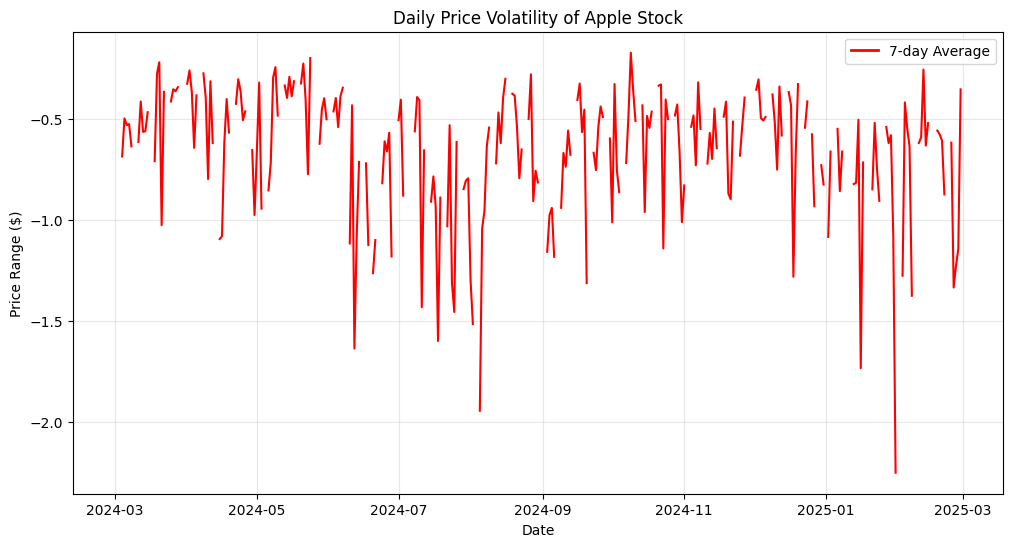

Average daily volatility: $-0.66
Maximum daily volatility: $-0.17 on 2024-10-09


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('apple_stock_1year_1h.csv', skiprows=1)

print("Available columns:", df.columns.tolist())

date_column = df.columns[0]
df['Datetime'] = pd.to_datetime(df[date_column])
df = df.set_index('Datetime')

# Look for High and Low price columns with different possible names
high_variants = ['high', 'High', 'HIGH']
low_variants = ['low', 'Low', 'LOW']

# Find which column names match our High/Low variants
high_col = None
for col in high_variants:
    if col in df.columns:
        high_col = col
        break

low_col = None
for col in low_variants:
    if col in df.columns:
        low_col = col
        break

if high_col and low_col:
    print(f"Using {high_col} and {low_col} for volatility calculation")
    df['Volatility'] = df[high_col] - df[low_col]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Using {numeric_cols[0]} and {numeric_cols[1]}")
    df['Volatility'] = df[numeric_cols[0]] - df[numeric_cols[1]]

daily_volatility = df['Volatility'].resample('D').mean()


plt.figure(figsize=(12, 6))


plt.plot(daily_volatility.index, daily_volatility.values, color='red')


plt.plot(daily_volatility.index, daily_volatility.rolling(window=7).mean(), 
         color='red', linewidth=2, label='7-day Average')


plt.xlabel('Date')
plt.ylabel('Price Range ($)')
plt.title('Daily Price Volatility of Apple Stock')
plt.grid(True, alpha=0.3)
plt.legend()


plt.show()


print(f"Average daily volatility: ${daily_volatility.mean():.2f}")
print(f"Maximum daily volatility: ${daily_volatility.max():.2f} on {daily_volatility.idxmax().strftime('%Y-%m-%d')}")


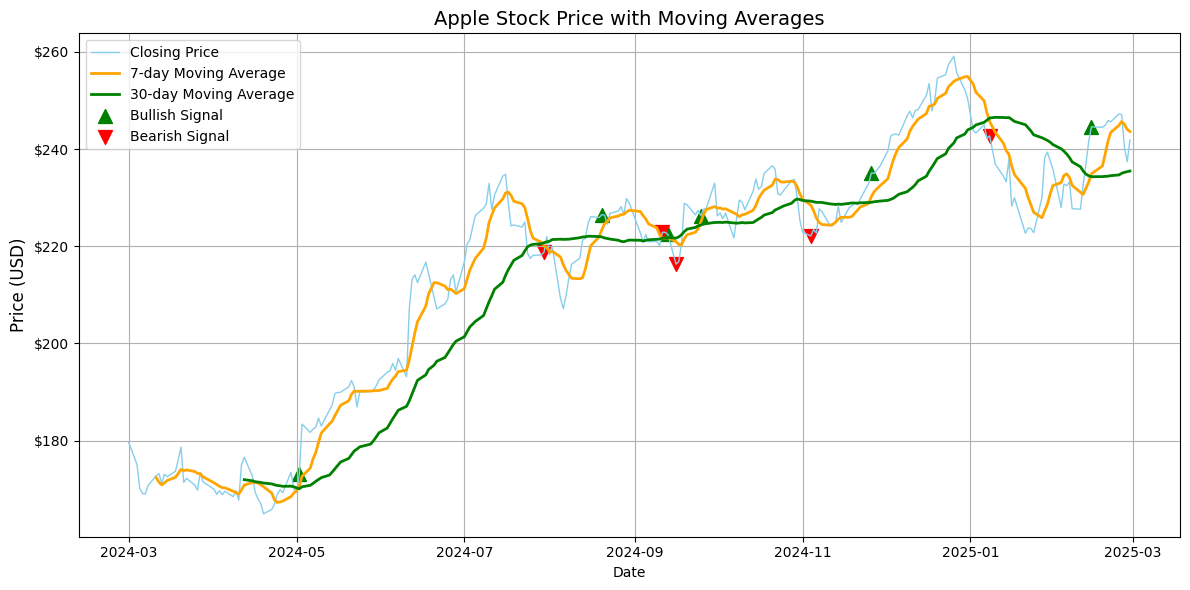

Bullish signals (short MA crosses above long MA):
- 2024-05-02
- 2024-08-20
- 2024-09-13
- 2024-09-25
- 2024-11-26
- 2025-02-14

Bearish signals (short MA crosses below long MA):
- 2024-07-30
- 2024-09-11
- 2024-09-16
- 2024-11-04
- 2025-01-08


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('apple_stock_1year_1h.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

daily_data = df['Close'].resample('D').last().dropna()

ma_short = daily_data.rolling(window=7).mean() 
ma_long = daily_data.rolling(window=30).mean()  

plt.figure(figsize=(12, 6))

plt.subplots_adjust(left=0.15)

plt.plot(daily_data.index, daily_data, label='Closing Price', color='skyblue', linewidth=1)
plt.plot(ma_short.index, ma_short, label='7-day Moving Average', color='orange', linewidth=2)
plt.plot(ma_long.index, ma_long, label='30-day Moving Average', color='green', linewidth=2)

bullish = (ma_short > ma_long) & (ma_short.shift(1) <= ma_long.shift(1))  
bearish = (ma_short < ma_long) & (ma_short.shift(1) >= ma_long.shift(1))  


plt.scatter(daily_data.index[bullish], daily_data[bullish], color='green', s=100, 
            marker='^', label='Bullish Signal')
plt.scatter(daily_data.index[bearish], daily_data[bearish], color='red', s=100, 
            marker='v', label='Bearish Signal')


from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))


plt.xlabel('Date')
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Apple Stock Price with Moving Averages', fontsize=14)
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


bullish_dates = daily_data.index[bullish].strftime('%Y-%m-%d').tolist()
bearish_dates = daily_data.index[bearish].strftime('%Y-%m-%d').tolist()

print("Bullish signals (short MA crosses above long MA):")
for date in bullish_dates:
    print(f"- {date}")

print("\nBearish signals (short MA crosses below long MA):")
for date in bearish_dates:
    print(f"- {date}")
